In [5]:
from npy_append_array import NpyAppendArray
import numpy as np
#import sys
import matplotlib.pyplot as plt
import yaml
from scipy import signal


#from modules.filters import *
"""ToDo das als import"""
def tag_peaks(input_data, prominence, distance, width):
    peaks = {}
    peaks_prop = {}
    for key in input_data.dtype.names:
        peaks[key], peaks_prop[key] = signal.find_peaks(
            input_data[key], prominence=prominence[key], distance=distance[key], width=width[key]
        )
    return peaks, peaks_prop

In [6]:
messung="1"

#later to be imported from config_dict
sample_time_ns = 256
analogue_offset = 0*1000

trigger_channel = 'ch2'
non_trigger_channel ='ch1'

channel_names=np.array(['ch1','ch2'])




peak_minimal_prominence = {'ch1': 200, 'ch2': 200}
peak_minimal_distance = {'ch1': 400, 'ch2': 400}
peak_minimal_width = {'ch1': 10, 'ch2': 10}

gradient_lower_bound = {'ch1': 0, 'ch2': 0}
gradient_upper_bound = {'ch1': 0, 'ch2': 0}


number_of_samples=1000


window_us=8
window=window_us*1000/256






color_table={'ch1': "tab:orange", 'ch2': "tab:blue"}

In [7]:
def import_data(filename, number_of_samples, channel_names):
    """
    Convert recorded pulses into a structured array, similar to how it would be handled by mimoCorb.

    Parameters:
    filename (str): Path to the file containing the recorded pulse data.
    number_of_samples (int): Number of samples to consider for each channel.
    channel_names (list): List of channel names.

    Returns:
    np.ndarray: Structured array containing the recorded pulse data.
    """
    # Load the data from the file using memory mapping to handle large files efficiently
    data = np.load(filename, mmap_mode='r')
    
    # Define the data type for each channel with the given number of samples
    dtype_sample = f'{number_of_samples}int16'
    dtype = np.dtype([(channel, dtype_sample) for channel in channel_names])
    
    # Initialize the structured array with the correct dtype
    structured_data = np.zeros(len(data), dtype=dtype)
    
    # Populate the structured array with data
    for i, record in enumerate(data):
        for j, channel in enumerate(channel_names):
            structured_data[i][channel] = record[j][:number_of_samples]
    
    # Print the number of recorded triggers
    print("Data read successfully, recorded triggers =", structured_data.size)
    
    return structured_data


In [4]:
data=import_data("measurements/measurement_3_" + messung +"min.npy",1000, channel_names)

if trigger_channel not in channel_names:
     raise ValueError(f"Trigger channel '{trigger_channel}' is not in the list of channel names.")
  



Data read successfully, recorded triggers = 2752


In [5]:
def tag_peaks_wtf(input_data, prominence, distance, width):
    

    peaks_1, peaks_prop_1 = signal.find_peaks(
            input_data[0], prominence=prominence, distance=distance, width=width
        )
    
    peaks_2, peaks_prop_2 = signal.find_peaks(
            input_data[1], prominence=prominence, distance=distance, width=width
        )
    
    peaks=np.array([peaks_1,peaks_2])
    peaks_prop=np.array([peaks_prop_1,peaks_prop_2])
    return peaks, peaks_prop

def coincidence(peaks_1,peaks_2,delta_channel):
    for trigger_peak in peaks_2:
        for comparison_peak in peaks_1:
            if abs(trigger_peak-comparison_peak)<=delta_channel:
                return True
            else: 
                return False

In [18]:
def peak_height(data,peaks,peaks_prop):
    """This module takes a 1d array, and the peak position and properties (from scipy.signal.find_peaks) and returns the indizes of the starting position of each peak

        the start of the peak is here defined as the first time the gradient of the data is 0 before the left_ips of the peak
        
        ToDo: add the option to set a limit for the gradient
    """
    number_of_peaks=len(peaks)
    gradient=np.gradient(data)
    heights=np.zeros(number_of_peaks)
    peaks=np.insert(peaks,0,0)
    for i in range(number_of_peaks):
        lb=peaks[i]
        print(peaks_prop)
        rb=int(peaks_prop['left_ips'][i])
        d,g=data[lb:rb],gradient[lb:rb]
        non_zeros=np.nonzero(np.equal(g,np.zeros(len(g))))
        start=non_zeros[0][-1]
        heights[i]=data[lb]-data[start]
    return heights
        


In [24]:
def tag_pulses(input_data):   
    """find all valid pulses 

    This function to be called by instance of class mimoCoRB.rbTransfer

        Args:  input data as structured ndarray

        Returns: list of parameterized pulses
    """

    # Find all the peaks and store them in a dictionary
    peaks, peaks_prop = tag_peaks(input_data, peak_minimal_prominence, peak_minimal_distance, peak_minimal_width)

    #print(peaks[trigger_channel])
    # Search for coincidences
    coincidence_peaks={'ch1':[],'ch2':[]}
    coincidence_peaks_prop={'ch1':[],'ch2':[]}
    for trigger_peak,trigger_peak_prop in zip(peaks[trigger_channel],peaks_prop[trigger_channel]):
        for coincidence_peak,coincidence_peak_prop in zip(peaks[non_trigger_channel],peaks_prop[non_trigger_channel]):
            if np.abs(trigger_peak-coincidence_peak)<window:
                coincidence_peaks[trigger_channel].append(trigger_peak)
                coincidence_peaks[non_trigger_channel].append(coincidence_peak)
                coincidence_peaks_prop[trigger_channel].append(trigger_peak_prop)
                coincidence_peaks_prop[non_trigger_channel].append(coincidence_peak_prop)
    #print(coincidence_peaks)
    return coincidence_peaks,coincidence_peaks_prop
    
        
        
                
                
            
                
    
    #print(peaks)

    """peak_data= np.zeros( (1,), dtype=pulse_par_dtype)
    for key in peaks.keys():
        for position, height, left_ips, right_ips in zip(
                peaks[key], peaks_prop[key]['prominences'],
                peaks_prop[key]['left_ips'], peaks_prop[key]['right_ips']):
            if np.abs(reference_position - position) < trigger_position_tolerance:
                peak_data[0][key+'_position'] = position
                peak_data[0][key+'_height'] = input_data[key][position] - analogue_offset #height
                left = int(np.floor(left_ips))
                right = int(np.ceil(right_ips))
                peak_data[0][key+'_integral'] = \
                sum(input_data[key][left:right] - analogue_offset) * sample_time_ns * 1e-9/50/5"""
    return None

In [25]:
def tag_coincidences(input_data):   
    """find all valid pulses 

    This function to be called by instance of class mimoCoRB.rbTransfer

        Args:  input data as structured ndarray

        Returns: list of parameterized pulses coinciding with the first pulse in the trigger channel
    """
    keys=input_data.dtype.names
    coincidence_keys=[key for key in keys if key !=trigger_channel]
    
    # Find all the peaks and store them in a dictionary
    peaks, peaks_prop = tag_peaks(input_data, peak_minimal_prominence, peak_minimal_distance, peak_minimal_width)

    """   trigger_peak=peaks[trigger_channel][0]
    coincidence_peaks={key:[] for key in keys}
    coincidence_peaks_prop={key:{} for key in keys}
    for key in coincidence_keys:
        for coincidence_peak in peaks[key]
            if np.abs(trigger_peak-coincidence_peak)<window:
                coincidence_peaks[trigger_channel].append(trigger_peak)
                coincidence_peaks[key].append(coincidence_peak)
                coincidence_peaks_prop[trigger_channel].append(peaks_prop)"""
    
    # Search for coincidences
    coincidence_peaks={'ch1':[],'ch2':[]}
    for trigger_peak in peaks[trigger_channel]:
        for coincidence_peak in peaks[non_trigger_channel]:
            if np.abs(trigger_peak-coincidence_peak)<window:
                coincidence_peaks[trigger_channel].append(trigger_peak)
                coincidence_peaks[non_trigger_channel].append(coincidence_peak)
    #print(coincidence_peaks)
    return coincidence_peaks

In [26]:
#Zielfunktion
"""
    Nimmt als input die data und returnt möglichst schnell None, falls keine Coincidence gefunden wird,
    falls coincidence gefunden wird returnt es die Höhe der beiden Pulse
    
    evtl variation ganzen Plot speichern
"""

def coincidence_height(input_data):
    keys=input_data.dtype.names
    coincidences=tag_coincidences(input_data)
    
    
    
    
    
    energys={'ch1': [], 'ch2': []}    
    for d in data[0:1]:
        f_return=coincidence_height(d)
        for key in channel_names:
            energys[key].append(f_return[key])

['prominences']


TypeError: list indices must be integers or slices, not str

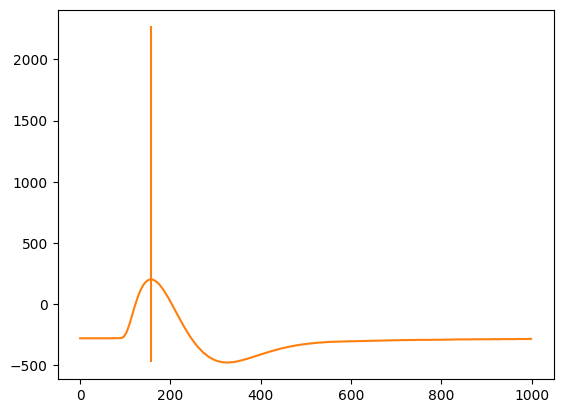

In [27]:
#n_samples = len(data[0,0])
#xplt = 0.5 + np.linspace(0, n_samples, num=n_samples, endpoint=True)
#fig = plt.figure("Oscillogram", figsize=(8,6))

i=0
heights={'ch1':[],'ch2':[]}

for d in data[0:500]:
    peaks,peaks_prop=tag_pulses(d)
    if peaks=={'ch1': [], 'ch2': []}:
        continue
        
    ymin=min([np.min(d[key]) for key in channel_names])
    ymax=max([np.max(d[key]) for key in channel_names])
    
    
    for key in channel_names:
        plt.plot(d[key],label=key,color=color_table[key])
        plt.vlines(peaks[key],ymin=ymin,ymax=ymax,color=color_table[key])
        heights[key].append(peak_height(d[key],peaks[key],peaks_prop[key]))
    plt.legend()
    plt.show()


#print(i)